# Prepare analysis

This notebook fetches all data related to persons' interest ties from the OpenParlData API.

In [64]:

# Notebook config
%reset -f
%reload_ext autoreload
%autoreload 2

In [144]:
# Imports
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

from util.analysis import prepare_regression_analysis
from util.interests_per_body import analyze_declarations_by_body
from util.interests_per_member import prepare_interests, analyze_declarations_by_member
from util.lang import get_lang
from util.memberships import prepare_memberships
from util.parliaments import load_parliaments_data


In [145]:
# Library config
print(np.version.version)
pd.options.mode.copy_on_write = True

2.4.2


In [146]:
# Notebook config

# Paths
out_dir = Path('scraped')
bodies_dir = Path(out_dir, 'bodies')
interests_dir = Path(out_dir, 'interests')
sources_dir = Path('sources')

In [147]:
# Load bodies data
bodies_data = None

with open(os.path.join(bodies_dir, 'bodies.json'), 'r', encoding='utf-8') as bodies_json_output:
    bodies_data = json.load(bodies_json_output)['data']

In [148]:
# Load general parliaments data
df_parliaments = load_parliaments_data(os.path.join(sources_dir, 'je-d-17.02.05.01.03.xlsx'))

In [149]:
# Create df
raw_records = []

# Load and insert interests data
for body in bodies_data:
    body_key = body['body_key']
    json_path = os.path.join(interests_dir, f'interests_{body_key}.json')

    interests_data = None
    with open(os.path.join(json_path), 'r', encoding='utf-8') as interests_json_output:
        interests_data = json.load(interests_json_output)['data']
        raw_records += interests_data

df_members = pd.DataFrame.from_records(raw_records)
df_members['function_latest'] = df_members['function_latest'].apply(func=get_lang)
df_members['party_harmonized'] = df_members['party_harmonized'].apply(func=get_lang)
df_members['website_parliament_url'] = df_members['website_parliament_url'].apply(func=get_lang)
df_members['interests_list'] = df_members['interests'].apply(lambda x: x['data'] if isinstance(x, dict) else [])
df_members['memberships_list'] = df_members['memberships'].apply(lambda x: x['data'] if isinstance(x, dict) else [])

df_members = df_members.drop(columns=['interests', 'memberships'])

# interests
df_interests = prepare_interests(df_members)

# memberships
df_memberships = prepare_memberships(df_members)

# analysis by member
df_analysis_by_member = analyze_declarations_by_member(df_memberships, df_interests, df_parliaments)

# analysis by body
df_analysis_by_body = analyze_declarations_by_body(df_analysis_by_member, df_parliaments)

# final steps
df_regression_analysis = prepare_regression_analysis(df_analysis_by_member, df_analysis_by_body)


## Descriptive analysis

All univariate descriptive analyses of the dependent and independent variables should be summarized in a table.

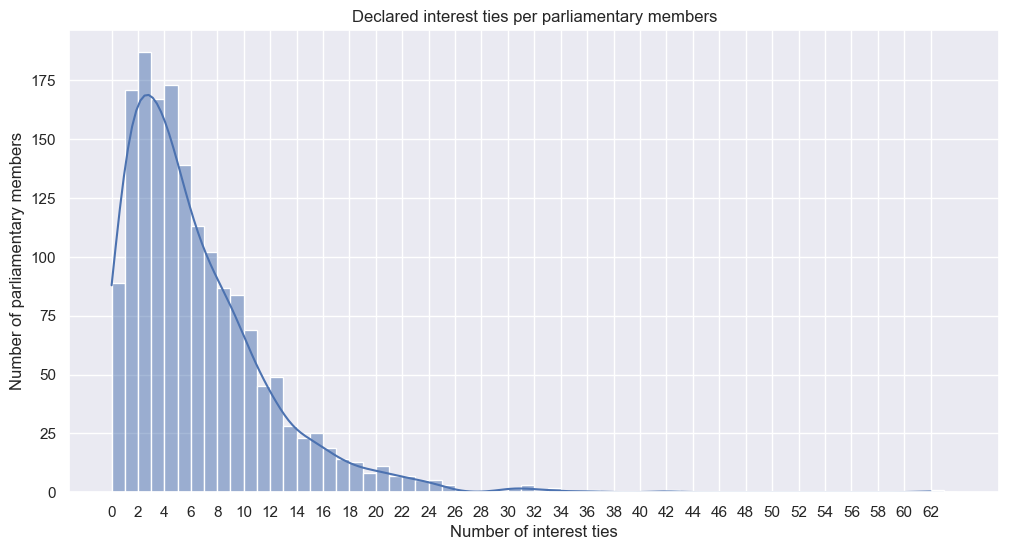

In [150]:
# Analysis of the DV
sns.set_theme(rc={ 'figure.figsize': (12, 6) })
sns.histplot(
    data=df_regression_analysis,
    x='num_interests',
    bins=64,
    binrange=(0, 64),
    stat='count',
    kde=True,
).set(
    title='Declared interest ties per parliamentary members',
    ylabel='Number of parliamentary members',
    xlabel='Number of interest ties',
)
plt.xticks(range(0, 64, 2))
print("")

In [151]:
# Description of the DV
df_regression_analysis['num_interests'].describe()

count    1653.000000
mean        6.188143
std         5.452885
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        62.000000
Name: num_interests, dtype: float64

In [152]:
# Description of one IV
df_regression_analysis['parliament_size'].describe()

count    1653.000000
mean      140.797943
std        53.796859
min        60.000000
25%       100.000000
50%       130.000000
75%       180.000000
max       246.000000
Name: parliament_size, dtype: float64

In [153]:
# Description of one IV
# df_regression_analysis['admin_level'].describe()
df_regression_analysis['admin_level'].value_counts()

admin_level
2    1409
1     244
Name: count, dtype: int64

<Axes: xlabel='parliament_size', ylabel='Count'>

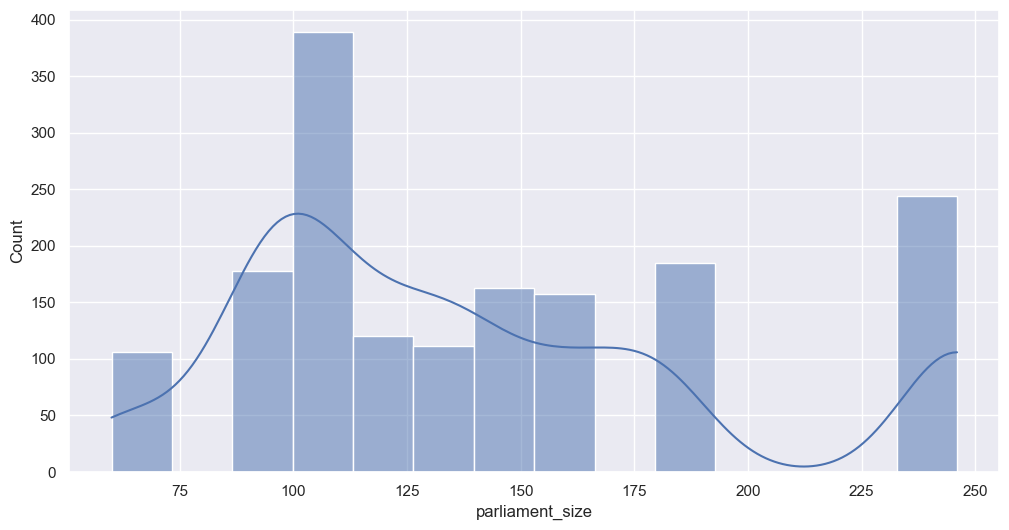

In [154]:
# Analysis of IV
sns.set_theme(rc={ 'figure.figsize': (12, 6) })
sns.histplot(
    data=df_regression_analysis,
    x='parliament_size',
    stat='count',
    kde=True,
)

# Hypothesis 1

MPs operating at higher administrative levels exhibit a higher number of disclosed vested interests than MPs at lower administrative levels.

In [155]:
# Model h1x (Poisson)
formula_h1x = "num_interests ~ parliament_size"

model_h1x = smf.glm(formula=formula_h1x, data=df_regression_analysis, family=sm.families.Poisson())
results_h1x = model_h1x.fit()

print(results_h1x.summary())
print(" ")
print(results_h1x.pearson_chi2 / results_h1x.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_interests   No. Observations:                 1653
Model:                            GLM   Df Residuals:                     1651
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5977.1
Date:                Thu, 12 Feb 2026   Deviance:                       6564.3
Time:                        14:53:40   Pearson chi2:                 7.76e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2273
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.2920      0.028     

In [169]:
# Model h1a (Negative Binominal)
formula_h1a = "num_interests ~ np.log2(parliament_size)"

model_h1a = smf.negativebinomial(
    formula=formula_h1a,
    data=df_regression_analysis,
)
results_h1a = model_h1a.fit(
    cov_type="cluster",
    cov_kwds={ "groups": df_regression_analysis["body_key"] }
)
print(np.exp(results_h1a.params))
print(results_h1a.summary())

Optimization terminated successfully.
         Current function value: 2.817787
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
Intercept                   0.492748
np.log2(parliament_size)    1.428872
alpha                       1.657677
dtype: float64
                     NegativeBinomial Regression Results                      
Dep. Variable:          num_interests   No. Observations:                 1653
Model:               NegativeBinomial   Df Residuals:                     1651
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                0.009738
Time:                        15:19:56   Log-Likelihood:                -4657.8
converged:                       True   LL-Null:                       -4703.6
Covariance Type:              cluster   LLR p-value:                 1.056e-21
                               coef    std err          z      P>|z|  

In [163]:
# Model h1b
formula_h1b = "num_interests ~ np.log2(parliament_size) + C(gender) + C(party) + tenure_years"
model_h1b = smf.negativebinomial(
    formula=formula_h1b,
    data=df_regression_analysis,
)
results_h1b = model_h1b.fit(
    method="lbfgs",
    maxiter=200,
    cov_type="cluster",
    cov_kwds={ "groups": df_regression_analysis["body_key"] }
)
print(results_h1b.summary())

Intercept                                 0.201246
C(gender)[T.1]                            0.861183
C(party)[T.Schweizerische Volkspartei]    1.415356
C(party)[T.Sozialdemokratische Partei]    1.665397
C(party)[T.FDP.Die Liberalen]             2.503434
C(party)[T.Die Mitte]                     1.943441
C(party)[T.Die Grünen]                    1.351839
C(party)[T.Other]                         1.380728
C(party)[T.Grünliberale Partei]           1.582475
C(party)[T.Evangelische Volkspartei]      1.627343
np.log2(parliament_size)                  1.498831
tenure_years                              1.012326
alpha                                     1.558069
dtype: float64
                     NegativeBinomial Regression Results                      
Dep. Variable:          num_interests   No. Observations:                 1653
Model:               NegativeBinomial   Df Residuals:                     1641
Method:                           MLE   Df Model:                           11
Date: 

# Hypothesis 2

MPs operating in larger parliaments exhibit a higher number of disclosed vested interests than MPs in smaller parliaments.

In [167]:
# Model h2a
formula_h2a = 'num_interests ~ C(admin_level)'
model_h2a = smf.negativebinomial(
    formula=formula_h2a,
    data=df_regression_analysis,
)
results_h2a = model_h2a.fit(
    #method="lbfgs",
    #maxiter=200,
    cov_type="cluster",
    cov_kwds={ "groups": df_regression_analysis["body_key"] }
)
print(results_h2a.summary())

Optimization terminated successfully.
         Current function value: 2.825045
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
                     NegativeBinomial Regression Results                      
Dep. Variable:          num_interests   No. Observations:                 1653
Model:               NegativeBinomial   Df Residuals:                     1651
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                0.007188
Time:                        15:19:28   Log-Likelihood:                -4669.8
converged:                       True   LL-Null:                       -4703.6
Covariance Type:              cluster   LLR p-value:                 1.986e-16
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              

In [166]:
# Model h2b
formula_h2b = 'num_interests ~ C(admin_level) + C(gender) + C(party) + tenure_years'
model_h2b = smf.negativebinomial(
    formula=formula_h2b,
    data=df_regression_analysis,
)
results_h2b = model_h2b.fit(
    method="lbfgs",
    maxiter=200,
    cov_type="cluster",
    cov_kwds={ "groups": df_regression_analysis["body_key"] }
)
print(np.exp(results_h2b.params))
print(results_h2b.summary())

Intercept                                 4.024979
C(admin_level)[T.2]                       0.614184
C(gender)[T.1]                            0.876335
C(party)[T.Schweizerische Volkspartei]    1.907643
C(party)[T.Sozialdemokratische Partei]    2.168904
C(party)[T.FDP.Die Liberalen]             3.209940
C(party)[T.Die Mitte]                     2.485994
C(party)[T.Die Grünen]                    1.777884
C(party)[T.Other]                         1.740916
C(party)[T.Grünliberale Partei]           2.212594
C(party)[T.Evangelische Volkspartei]      2.253264
tenure_years                              1.012392
alpha                                     1.577625
dtype: float64
                     NegativeBinomial Regression Results                      
Dep. Variable:          num_interests   No. Observations:                 1653
Model:               NegativeBinomial   Df Residuals:                     1641
Method:                           MLE   Df Model:                           11
Date: 

# Discussion

In [161]:
sg = Stargazer([results_h1a, results_h1b, results_h2a, results_h2b])

cov_names = sg.cov_names
sg.covariate_order(
    [
        'Intercept',
        'np.log2(parliament_size)',
        'C(admin_level)[T.2]',
        'tenure_years',
        'C(gender)[T.1]',
        'C(party)[T.Schweizerische Volkspartei]',
        'C(party)[T.Sozialdemokratische Partei]',
        'C(party)[T.FDP.Die Liberalen]',
        'C(party)[T.Die Mitte]',
        'C(party)[T.Die Grünen]',
        'C(party)[T.Grünliberale Partei]',
        'C(party)[T.Evangelische Volkspartei]',
        'C(party)[T.Other]',
    ]
)

sg